In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle

In [31]:
seed = 23
protected = False
sam = False
import_cols = [
    'RESEARCH_AND_DEVELOPMENT',
    'DOMESTIC_SHELTER',
    'TYPE_OF_SET_ASIDE',
    'SOLICITATION_ID',
    'CONSTRUCTION_FIRM',
    'CO_BUS_SIZE_DETERMINATION',
    'CAGE_CODE',
    'VETERAN_OWNED_FLAG',
    'CORP_ENTITY_NOT_TAX_EXEMPT',
    'FUNDING_DEPARTMENT_ID',
    # 'FUNDING_AGENCY_NAME',
    'FUNDING_AGENCY_ID',
    # 'FUNDING_OFFICE_NAME',
    # 'FUNDING_OFFICE_ID',
    'SERVICE_PROVIDER',
    'PRODUCT_OR_SERVICE_TYPE',
    # 'MODIFICATION_NUMBER',
    'PIID',
    'FOUNDATION',
    # 'EVALUATED_PREFERENCE',
    'SRDVOB_FLAG',
    'CORP_ENTITY_TAX_EXEMPT',
    'MANUFACTURER_OF_GOODS',
    'VENDOR_ADDRESS_COUNTRY_NAME',
    'VENDOR_ADDRESS_ZIP_CODE',
    'SDB',
    'VETERINARY_HOSPITAL',
    'COMMUNITY_CORP_OWNED_FIRM',
    'DOT_CERTIFIED_DISADV_BUS',
    'PRINCIPAL_NAICS_CODE',
    'EDUCATIONAL_INSTITUTION_FLAG',
    'LIMITED_LIABILITY_CORPORATION',
    'EXTENT_COMPETED',
    'FEDERALLY_FUNDED_R_AND_D_CORP',
    'SOLE_PROPREITORSHIP',
    'WOMEN_OWNED_FLAG',
    'ARCHITECTURE_AND_ENGINEERING',
    'HISPANIC_SERVICING_INSTITUTION',
    'IDV_PIID',
    'PLACE_OF_MANUFACTURE',
    # 'IDV_EXTENT_COMPETED',
    'AWARD_FISCAL_YEAR',
    # 'IDV_SIGNED_DATE',
    'FIRM_8A_FLAG',
    'SMALL_AGRICULTURAL_COOPERATIVE',
    'PARTNERSHIP_OR_LLP',
    'DOLLARS_OBLIGATED',
    # 'IDV_NUMBER_OF_OFFERS',
    'FOR_PROFIT_ORGANIZATION',
    # 'AWARD_OR_IDV',
    'FIRM8A_JOINT_VENTURE',
    # 'IDV_CONTRACTING_AGENCY_ID',
    'NUMBER_OF_OFFERS_RECEIVED'
]
if protected:
    import_cols = import_cols + ['ANNUAL_REVENUE', 'NUMBER_OF_EMPLOYEES']


import_years = [2019, 2020, 2021, 2022, 2023]
top_n_agencies = 0
min_class_size = 20

model_cols = [
    'RESPONSE',
    'RESEARCH_AND_DEVELOPMENT',
    'DOMESTIC_SHELTER',
    # 'TYPE_OF_SET_ASIDE',
    'CONSTRUCTION_FIRM',
    'VETERAN_OWNED_FLAG',
    'CORP_ENTITY_NOT_TAX_EXEMPT',
    'SERVICE_PROVIDER',
    'PRODUCT_OR_SERVICE_TYPE',
    # 'MODIFICATION_NUMBER',
    # 'PIID',
    'FOUNDATION',
    # 'EVALUATED_PREFERENCE',
    'SRDVOB_FLAG',
    'CORP_ENTITY_TAX_EXEMPT',
    'MANUFACTURER_OF_GOODS',
    'VENDOR_ADDRESS_ZIP_CODE',
    #'VENDOR_STATE', #FEATURE ENGINEERED BELOW
    'SDB',
    'VETERINARY_HOSPITAL',
    'COMMUNITY_CORP_OWNED_FIRM',
    'DOT_CERTIFIED_DISADV_BUS',
    'PRINCIPAL_NAICS_CODE',
    'EDUCATIONAL_INSTITUTION_FLAG',
    'LIMITED_LIABILITY_CORPORATION',
    'FEDERALLY_FUNDED_R_AND_D_CORP',
    'SOLE_PROPREITORSHIP',
    'WOMEN_OWNED_FLAG',
    'ARCHITECTURE_AND_ENGINEERING',
    'HISPANIC_SERVICING_INSTITUTION',
    # 'IDV_PIID',
    'PLACE_OF_MANUFACTURE_CLASS',
    # 'IDV_EXTENT_COMPETED',
    # 'AWARD_FISCAL_YEAR',
    # 'IDV_SIGNED_DATE',
    'FIRM_8A_FLAG',
    'SMALL_AGRICULTURAL_COOPERATIVE',
    'PARTNERSHIP_OR_LLP',
    # 'IDV_NUMBER_OF_OFFERS',
    'FOR_PROFIT_ORGANIZATION',
    # 'AWARD_OR_IDV',
    'FIRM8A_JOINT_VENTURE',
    # 'IDV_CONTRACTING_AGENCY_ID',
    'CONTRACTS_PER_YEAR'
]
if protected:
    model_cols = model_cols + ['ANNUAL_REVENUE', 'NUMBER_OF_EMPLOYEES']

min_importance = 0.001 #at 0.015 we finally get zip, 
col_tree_depth = 10
hard = False

n_trees = 1000
max_depth = 25
top_n_classes = 20

## Import Data

In [3]:
def import_dataset(import_cols, years, sam=True):
    """
    Imports, cleans, and joins our data with specified columns and years
    Inputs: 
        import_cols (list [str] of column names)
        years (list [int] of years to import)
        sam (bool of whether to merge with sam dataset)
    Output:
        Cleaned, filtered, and joined dataframe
    """
    if sam:
        SAM = pd.read_csv('SAM.CSV') #imports SAM df
    
    year_dfs = []
    for year in years:
        if protected: #whether we're using protected columns or not
            temp_df = pd.read_parquet('fy' + str(year) + '.parquet', columns=import_cols)
        else:
            temp_df = pd.read_parquet(str(year) + '.parquet', columns=import_cols) #import year's data
        
        temp_df = temp_df[temp_df['CO_BUS_SIZE_DETERMINATION'] == "SMALL BUSINESS"] #filter for small business
        temp_df = temp_df[temp_df['VENDOR_ADDRESS_COUNTRY_NAME'] == "UNITED STATES"] #filter for US
        temp_df = temp_df[temp_df['EXTENT_COMPETED'].isin(["A", "D", "E", "CDO"])] #filter for competition
        
        # temp_df['DOLLARS_OBLIGATED'] = pd.to_numeric(temp_df['DOLLARS_OBLIGATED'], errors='coerce') #make numeric
        
        if sam:
            temp_m = pd.merge(temp_df, SAM, on="CAGE_CODE", how="inner") #merge with SAM
        else:
            temp_m = temp_df
        
        # idx = temp_m.groupby(['SOLICITATION_ID','CAGE_CODE'])['DOLLARS_OBLIGATED'].idxmax() #find initial contract win
        # temp_m = temp_m.loc[idx] #filter to initial contract win
        
        temp_m = temp_m[temp_m['DOLLARS_OBLIGATED'] > 0] #filter DOLLARS_OBLIGATED
        
        print(f'{year} shape: {temp_m.shape}')
        year_dfs.append(temp_m) #append year dataset to list of year datasets
    
    merged_df = pd.concat(year_dfs, ignore_index=True) #merge all years
    
    for df in year_dfs:
        del df
    del year_dfs #delete the individual dfs from memory
    
    merged_df['contract_id'] = merged_df['PIID'] + merged_df['IDV_PIID']
    # idx = merged_df.groupby(['SOLICITATION_ID','CAGE_CODE'])['DOLLARS_OBLIGATED'].idxmax() #find initial contracts
    idx = merged_df.groupby(['contract_id', 'CAGE_CODE'])['DOLLARS_OBLIGATED'].idxmax() #find initial contracts a different way lmao
    filtered_merged_df = merged_df.loc[idx] #filter to initial contract
    
    print(f'total shape: {filtered_merged_df.shape}')
    
    #place of manufacture conversion
    def convert_place_of_manufacture(value):
        if value == 'D':
            return 'YES' #manufactured in US
        elif value == 'C':
            return 'NO' #not manufactured in US
        elif value in ['N/A', 'A', 'G', 'E', 'H', 'L', 'J', 'F', 'K', 'B', 'I']:
            return 'NONE'
        else:
            return 'NONE' #N/A (provides a service or doesn't qualify fully)
    
    #clean up individual columns
    filtered_merged_df['FUNDING_DEPARTMENT_ID'] = filtered_merged_df['FUNDING_DEPARTMENT_ID'].str.strip() #clean dept ID
    if protected:
        filtered_merged_df['ANNUAL_REVENUE'] = filtered_merged_df['ANNUAL_REVENUE'].astype(float)
    # filtered_merged_df['IDV_PIID'] = filtered_merged_df['IDV_PIID'].str.strip() #clean IDV PIID
    # filtered_merged_df['PIID'] = filtered_merged_df['PIID'].str.strip() #clean PIID
    filtered_merged_df['PLACE_OF_MANUFACTURE_CLASS'] = filtered_merged_df['PLACE_OF_MANUFACTURE'].apply(convert_place_of_manufacture) #clean PLACE_OF_MANUFACTURE
    filtered_merged_df['VENDOR_ADDRESS_ZIP_CODE'] = filtered_merged_df['VENDOR_ADDRESS_ZIP_CODE'].astype(str).str[:5] #clean ZIP to 5-digit
    filtered_merged_df = filtered_merged_df[filtered_merged_df['VENDOR_ADDRESS_ZIP_CODE'].str.len()==5]
    filtered_merged_df['TYPE_OF_SET_ASIDE'] = filtered_merged_df['TYPE_OF_SET_ASIDE'].fillna('NONE') #assume NA = NONE
    
    filtered_merged_df = filtered_merged_df.dropna(subset=filtered_merged_df.columns.difference(['PLACE_OF_MANUFACTURE'])) #remove rows with NAs here
    
    print(f'total filtered shape: {filtered_merged_df.shape}')
    
    return filtered_merged_df

In [4]:
df0 = import_dataset(import_cols, import_years, sam=False)

2019 shape: (1772611, 43)
2020 shape: (1659942, 43)
2021 shape: (1916684, 43)
2022 shape: (1979453, 43)
2023 shape: (1866515, 43)
total shape: (8616491, 44)
total filtered shape: (266059, 45)


## Create Response Variable

In [5]:
def response_var(df, top_n, min_class_size=1):
    """
    Creates a new response variable by splitting the top_n most common agencies into their respective offices,
    then filter the dataframe so only classes with at least min_class_size rows remain
    Inputs:
        df (dataframe output from import_dataset())
        top_n (integer of top n agencies [0, max])
        min_class_size (integer of minimum # of observations a class can have to be a valid response)
    Outputs:
        dataframe with additional RESPONSE column, filtered
    """
    if top_n > 0:
        n_agencies = df['FUNDING_AGENCY_ID'].value_counts().nlargest(top_n).index #get top n most common agencies
        df['RESPONSE'] = np.where(df['FUNDING_AGENCY_ID'].isin(n_agencies), df['FUNDING_OFFICE_ID'], df['FUNDING_AGENCY_ID']) #make RESPONSE, splitting most common agencies into offices
    else:
        df['RESPONSE'] = df['FUNDING_AGENCY_ID']
    
    class_sizes = df['RESPONSE'].value_counts()
    classes_to_keep = class_sizes[class_sizes >= min_class_size].index
    df = df[df['RESPONSE'].isin(classes_to_keep)]
    
    print(f"{df['RESPONSE'].nunique()} unique response classes")
    
    return df

In [6]:
df = response_var(df0, top_n_agencies, min_class_size)

163 unique response classes


## Perform any Feature Engineering Here

In [7]:
df.loc[:,'PRINCIPAL_NAICS_CODE'] = df['PRINCIPAL_NAICS_CODE'].str[:4]

In [8]:
contracts_per_year = df.groupby(['CAGE_CODE', 'AWARD_FISCAL_YEAR']).size().to_frame().reset_index()
contracts_per_year.columns = list(contracts_per_year.columns[:2]) + ['CONTRACTS_PER_YEAR']
df = df.merge(contracts_per_year, on=['CAGE_CODE', 'AWARD_FISCAL_YEAR'])

In [9]:
# zip_df = pd.read_csv('zip_code_database.csv', converters={'zip': str})
# zcdb = pd.Series(zip_df['state'].values,index=zip_df['zip']).to_dict()
# df.loc[:,'VENDOR_STATE'] = df["VENDOR_ADDRESS_ZIP_CODE"].map(zcdb, na_action='ignore')
# df = df[~df['VENDOR_STATE'].isna()]

In [10]:
df.loc[:,'VENDOR_ADDRESS_ZIP_CODE'] = df['VENDOR_ADDRESS_ZIP_CODE'].str[:1]

## Model Preprocessing

In [11]:
def preprocess_data(df, model_cols, train_test=True, train_size=0.8, scale_quant=True):
    """
    Preprocesses the dataframe appropriately after creating the response variable and after feature engineering
    Input:
        df (dataframe output from response_var())
        model_cols (list [str] of cols to use to model)
        train_test (bool of whether to split the data into train/test groups)
        train_size (float [0, 1] of proportion of training data to whole data)
        scale_quant (bool of whether to scale quantitative variables)
        
    Output:
        X (df of X values to be used in modeling, dummy encoded & scaled)
        y (series of y values for modeling, label encoded)
    """
    Xy = df[model_cols] #select only the modeling columns
    
    y = Xy['RESPONSE'] #initialize y
    X = Xy.drop('RESPONSE', axis=1) #initialize X
    
    enc = LabelEncoder()
    y = enc.fit_transform(y) #transform y into labeled column
    global class_ids 
    class_ids = enc.classes_
    
    categoricals = X.select_dtypes(include=['object', 'category']).columns.tolist()
    X_cat = pd.get_dummies(X[categoricals]) #one-hot encode categorical columns
    
    quantitatives = X.columns.difference(categoricals)
    if scale_quant and len(quantitatives) > 0:
        global scaler
        scaler = StandardScaler()
        X_quant = scaler.fit_transform(X[quantitatives]) #scale quantitative columns
        X_quant = pd.DataFrame(X_quant, columns=quantitatives)
        X_cat = X_cat.reset_index()
    else:
        X_quant = X[quantitatives]
    
    X = pd.concat([X_cat, X_quant], axis=1).drop('index', axis=1) #combine quant & cat subsets back into one df
    
    if train_test:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=seed)
        return X_train, X_test, y_train, y_test
    else:
        return X, y

In [12]:
X_train, X_test, y_train, y_test = preprocess_data(df, model_cols, train_test=True, train_size=0.8, scale_quant=True)

In [13]:
# pickle.dump(scaler, open('Dashboard_Scaler.pkl', 'wb'))

## Column Selection

In [14]:
def column_selection(X, y, col_tree_depth, cutoff=0.01, hard=True):
    """
    Takes in a preprocessed X and y, returning the columns selected by feature importance.
    If hard=True, the returned columns are exactly the variables above the cutoff value.
    If hard=False, returned columns will add ones that belong to the same group as those output (e.g.
    if ZIP_1, ZIP_0 are significant will also return the other ZIP_x variables)
    Input:
        X (df preprocessed by preprocess_data())
        y (series preprocessed by preprocess_data())
        col_tree_depth (int that dictates tree depth)
        cutoff (float [0,1] that controls the minimum importance)
        hard (bool that controls whether to only include columns above cutoff if True or adds 
        columns within the same group if False)
    Output:
        cols (list [str] of columns selected as significant)
    """
    
    forest = RandomForestClassifier(random_state=seed, max_depth=col_tree_depth)
    forest.fit(X, y)
    importances = forest.feature_importances_
    #std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=X.columns)
    
    important_cols = forest_importances[forest_importances >= cutoff].index
    
    if hard:
        print(len(important_cols))
        return sorted(list(important_cols)) #return only above cutoff columns
    if not hard:
        zips = []
        naics_codes = []
        set_asides = []
        
        if any(important_cols.str.startswith('VENDOR_ADDRESS_ZIP_CODE')): #add in all zip columns
            zips = ['VENDOR_ADDRESS_ZIP_CODE_' + str(i) for i in range(10)]
            
        if any(important_cols.str.startswith('PRINCIPAL_NAICS_CODE')): #add in all NAICS columns
            naics_codes = pd.Series(X.columns)[pd.Series(X.columns).str.startswith('PRINCIPAL')].to_list()
        
        final_cols = sorted(list(set(list(important_cols) + zips + naics_codes)))
        print(len(final_cols))
        return final_cols

In [15]:
final_cols = column_selection(X_train, y_train, col_tree_depth=col_tree_depth,
                              cutoff=min_importance, hard=hard)

239


In [35]:
# final_cols

In [17]:
# pickle.dump(final_cols, open('Dashboard_Columns.pkl', 'wb'))

In [37]:
X_test.shape

(53046, 267)

## Train Random Forest & Assess

In [18]:
def train_models(X_train, X_test, y_train, y_test, columns, top_n_classes, n_trees=1000, max_depth=2):
    X_train = X_train[columns]
    X_test = X_test[columns]
    
    # Initialize the Random Forest model
    random_forest = RandomForestClassifier(n_estimators=n_trees, max_depth=max_depth, random_state=seed,
                                           criterion="log_loss", class_weight="balanced_subsample",
                                           n_jobs=-1)

    # Train the Random Forest model on the training data
    random_forest.fit(X_train, y_train)
    
    return random_forest

In [19]:
def assess_models(model):
    top_ns = []
    accuracies = []
    probabilities = model.predict_proba(X_test[final_cols])
    for i in [1, 5, 10, 15, 20]:
        # Get the top n predicted classes for each sample
        top_n_indices = np.argsort(probabilities, axis=1)[:, -i:]

        # Check if the true label is in the top n predicted classes for each sample
        predicted_labels = model.classes_[top_n_indices]
        accurate_predictions = np.any(predicted_labels == y_test[:, np.newaxis], axis=1)

        # Calculate accuracy based on whether the true label is in the top n predicted classes
        accuracy = np.mean(accurate_predictions)
        accuracies += [accuracy]
        top_ns += [i]
    
    return pd.DataFrame({'Top-n': top_ns, 'Accuracy': accuracies})

In [32]:
%%time
forest_model = train_models(X_train, X_test, y_train, y_test,
                            columns=final_cols, top_n_classes=top_n_classes,
                            n_trees=n_trees, max_depth=max_depth)

CPU times: user 9min 34s, sys: 14.4 s, total: 9min 48s
Wall time: 1min 37s


In [33]:
# dfs = []
# for depth in [12, 14, 16, 18]:
#     for trees in [250, 500, 750, 1000]:
#         b, forest_model = train_models(X_train, X_test, y_train, y_test,
#                                                 columns=final_cols, top_n_classes=top_n_classes,
#                                                 n_trees=trees, max_depth=depth)
#         t_df = assess_models(forest_model)
#         t_df['Depth'] = depth
#         t_df['N_Trees'] = trees
#         dfs += [t_df]

# tuning_df = pd.concat(dfs).sort_values('Accuracy', ascending=False)

In [34]:
assess_df = assess_models(forest_model) #20 depth (93.1%), 25 depth (93.6%), 30 depth (93.8%)
assess_df

,Top-n,Accuracy
0,1,0.723184
1,5,0.872658
2,10,0.907024
3,15,0.924349
4,20,0.935792


<Axes: >

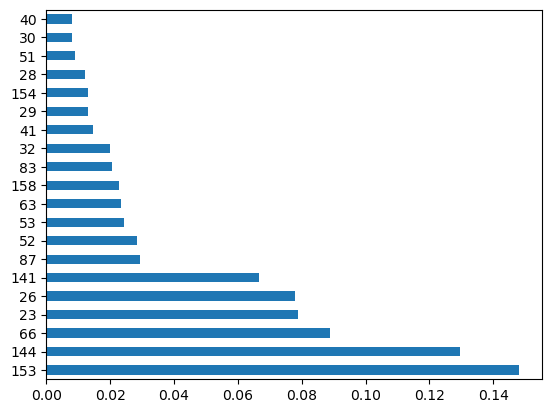

In [23]:
pd.Series(forest_model.predict_proba(X_test[final_cols])[12]).sort_values(ascending=False).head(20).plot.barh()

In [24]:
def contract_competition(agencies):
    results = {}
    for agency in agencies:
        subset_df = df0[df0['RESPONSE']==agency]
        if not subset_df.empty:
            lower_quantile = round(subset_df['NUMBER_OF_OFFERS_RECEIVED'].quantile(0.05),1)
            upper_quantile = round(subset_df['NUMBER_OF_OFFERS_RECEIVED'].quantile(0.95),1)
            average = round(subset_df['NUMBER_OF_OFFERS_RECEIVED'].mean(),1)

            results[agency] = (lower_quantile, average, upper_quantile)
        else:
            results[agency] = "No data available"
    return results

In [25]:
all_agencies = list(df0['RESPONSE'].unique())

In [26]:
n_contracts = contract_competition(all_agencies)

In [27]:
# pickle.dump(n_contracts, open('Agency_Contracts.pkl', 'wb'))

In [28]:
# pickle.dump(forest_model, open('Agency_Model_250.pkl', 'wb'))

In [29]:
class_id_dict = {}
for i, v in enumerate(class_ids):
    class_id_dict[i] = v

In [30]:
# pickle.dump(class_id_dict, open('Class_IDs.pkl', 'wb'))